# Import some handy Extentions

In [1]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
%matplotlib inline

# Display progress logs on stdout
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
# import sys  
# reload(sys)  
# sys.setdefaultencoding('utf8')

# Import Dependencies

In [66]:
from __future__ import print_function
from pprint import pprint
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, LinearSVR
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn.pipeline import Pipeline

import gensim
import pickle
import nltk
import codecs
import os
import gc # Collect Garabage
import re

from random import shuffle
from utilitis import plot_confusion_matrix, plot_learning_curve, plot_roc_curve
from plotting_func import *
from logistic_reg_inspection import get_most_important_features, plot_important_words


from BeautifulSoup import BeautifulSoup
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))


pd.set_option('display.max_colwidth', -1)

time: 49 ms


# Data Engineering

In [3]:
dtypes = {
    'review'      : np.unicode ,
    'sentiment' : np.int16
}
data = pd.read_csv("data/labeledTrainData.tsv", delimiter="\t", usecols=['review','sentiment'],
                                                encoding="utf-8", dtype=dtypes)
test = pd.read_csv("data/testData.tsv", delimiter="\t", usecols=['review'],
                                                encoding="utf-8", dtype=dtypes)                                                                                

import re, string
re_tok = re.compile(u'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

time: 971 ms


In [4]:
print('Data size: ',data.shape, "\n")
print ("Inspect the data...")
data.head(2)

Data size:  (25000, 2) 

Inspect the data...


,sentiment,review
0,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter."
1,1,"\The Classic War of the Worlds\"" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \""critics\"" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \""critics\"". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \""critics\"" perceive to be its shortcomings."""


time: 13.3 ms


In [5]:
print ("Inspect the data more...")
data.describe()

Inspect the data more...


,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


time: 55.4 ms


In [6]:
data.groupby("sentiment").count()

,review
sentiment,
0,12500
1,12500


time: 20.3 ms


## Note:

    -  1 >> means Positive sentiment with review >= 7
    -  0 >> means Negative sentiment with review <  5

In [7]:
# Basic Data Formatting

data_snt = data[["review","sentiment"]]
data_snt["sentiment"].replace(u'', np.nan, inplace=True)
data_snt.review.fillna(value='Unknown', inplace=True)
data_snt.dropna(inplace=True)
data_snt.drop_duplicates(inplace=True)

time: 235 ms


/home/alaa/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/alaa/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
data_snt.reset_index(drop=True, inplace=True)

time: 1.12 ms


In [9]:
# Basic Data Formatting
data_test = test[["review"]]
data_test.review.fillna(value='Unknown', inplace=True)

time: 6.48 ms


In [10]:
data_test.shape

(25000, 1)

time: 3.87 ms


In [11]:
data_test.reset_index(drop=True, inplace=True)

time: 1.95 ms


In [62]:
def review_to_words(raw_review, stopwords):
  
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).text
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stopwords]   
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

# Try with the first review
clean_review = review_to_words(data_snt["review"][4], stop_words)
print (clean_review)

superbly trashy wondrously unpretentious exploitation hooray pre credits opening sequences somewhat give false impression dealing serious harrowing drama need fear barely ten minutes later necks nonsensical chainsaw battles rough fist fights lurid dialogs gratuitous nudity bo ingrid two orphaned siblings unusually close even slightly perverted relationship imagine playfully ripping towel covers sister naked body stare unshaven genitals several whole minutes well bo sister judging dubbed laughter mind sick dude anyway kids fled russia parents nasty soldiers brutally slaughtered mommy daddy friendly smuggler took custody however even raised trained bo ingrid expert smugglers actual plot lifts years later facing ultimate quest mythical incredibly valuable white fire diamond coincidentally found mine things life ever made little sense plot narrative structure white fire sure lot fun watch time clue beating cause bet actors understood even less whatever violence magnificently grotesque ever

## Now, let's clean the whole corpus

In [14]:
num_reviews = len(data_snt.review.tolist())
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in xrange( 0, num_reviews):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d" % ( i+1, num_reviews ))                                                                    
    clean_train_reviews.append( review_to_words(data_snt["review"][i], stop_words ))

Cleaning and parsing the training set movie reviews...

Review 1000 of 24904
Review 2000 of 24904
Review 3000 of 24904
Review 4000 of 24904
Review 5000 of 24904
Review 6000 of 24904
Review 7000 of 24904
Review 8000 of 24904
Review 9000 of 24904
Review 10000 of 24904
Review 11000 of 24904
Review 12000 of 24904
Review 13000 of 24904
Review 14000 of 24904
Review 15000 of 24904
Review 16000 of 24904
Review 17000 of 24904
Review 18000 of 24904
Review 19000 of 24904
Review 20000 of 24904
Review 21000 of 24904
Review 22000 of 24904
Review 23000 of 24904
Review 24000 of 24904
time: 14 s


In [63]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data_snt['cleaned_review'] = clean_train_reviews
data_snt["tokens"] = data_snt["cleaned_review"].apply(tokenizer.tokenize)

time: 884 ms


In [65]:
data_snt.head(1)

,review,sentiment,cleaned_review,tokens
6520,"I viewed this movie in DVD format. My copy may have been affected but I was disappointed with the lack of menu screen for the DVD. I will say that my initial reason for viewing this movie was Claire Forlani. While fun to watch, I feel she didn't live up to my expectations that I have so far found from her other films. I actually was equally pleased to see Arkin turn in a humorous performance. The other two actors I wasn't very familiar with so I can't compare their performance, however they were fairly enjoyable also. The acting is the only endearing quality of this movie in my opinion. The story line, while some could say slightly compelling, lacked direction. I feel that the main problem stems from the script and not the direction of this film. If you enjoy any of these actors to a fair extent then I recommend this film, but otherwise leave it alone.",0,stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay br br visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice br br actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music br br lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working one kid let alone whole bunch performing complex dance scene br br bottom line movie people like mj one level another think people stay away try give wholesome message ironically mj bestest buddy movie girl michael jackson truly one talented people ever grace planet guilty well attention gave subject hmmm well know people different behind closed doors know fact either extremely nice stupid guy one sickest liars hope latter,"[stuff, going, moment, mj, started, listening, music, watching, odd, documentary, watched, wiz, watched, moonwalker, maybe, want, get, certain, insight, guy, thought, really, cool, eighties, maybe, make, mind, whether, guilty, innocent, moonwalker, part, biography, part, feature, film, remember, going, see, cinema, originally, released, subtle, messages, mj, feeling, towards, press, also, obvious, message, drugs, bad, kay, br, br, visually, impressive, course, michael, jackson, unless, remotely, like, mj, anyway, going, hate, find, boring, may, call, mj, egotist, consenting, making, movie, mj, fans, would, say, made, fans, true, really, nice, br, br, actual, feature, film, bit, finally, starts, minutes, excluding, smooth, criminal, sequence, joe, ...]"


time: 11.8 ms


In [19]:
data_snt.to_csv("cleaned_data/cleaned_training_reviews.csv", index=False, encoding="utf-8")

time: 7.98 s


In [20]:
num_reviews = len(data_test.review.tolist())
print ("Cleaning and parsing the testing set movie reviews...\n")
clean_test_reviews = []
for i in xrange( 0, num_reviews):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d" % ( i+1, num_reviews ))                                                                    
    clean_test_reviews.append( review_to_words(data_test["review"][i], stop_words ))

Cleaning and parsing the testing set movie reviews...

Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000
time: 14 s


In [21]:
data_test['cleaned_review'] = clean_test_reviews
data_test["tokens"] = data_test["cleaned_review"].apply(tokenizer.tokenize)

time: 1.07 s


In [22]:
data_test.to_csv("cleaned_data/cleaned_testing_reviews.csv", index=False, encoding='utf-8')

time: 7.84 s


In [23]:
def cv(data, analyzer= u'word'):
    """A function to creat BoW vectors of words """
    count_vectorizer = CountVectorizer(analyzer=analyzer)
    emb = count_vectorizer.fit_transform(data)
    print('Vectors shape: ', emb.shape, '\n')
    return emb, count_vectorizer

def tfidf(data, analyzer= u'word'):
    """A function to creat Tf-Idf BoW vectors of words """
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                                       min_df=3, max_df=0.9, strip_accents='unicode',
                                       use_idf=1, analyzer=analyzer,
                                       smooth_idf=1, sublinear_tf=1 )
    train = tfidf_vectorizer.fit_transform(data)
    print('Vectors shape: ', train.shape, '\n')
    return train, tfidf_vectorizer

time: 5.65 ms


# Do more EDA

In [154]:

data_snt["tokens"] = data_snt["cleaned_review"].apply(tokenizer.tokenize)
data_snt.head(1)

,review,sentiment,cleaned_review,tokens
0,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter.",1,stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay br br visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice br br actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music br br lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working one kid let alone whole bunch performing complex dance scene br br bottom line movie people like mj one level another think people stay away try give wholesome message ironically mj bestest buddy movie girl michael jackson truly one talented people ever grace planet guilty well attention gave subject hmmm well know people different behind closed doors know fact either extremely nice stupid guy one sickest liars hope latter,"[stuff, going, moment, mj, started, listening, music, watching, odd, documentary, watched, wiz, watched, moonwalker, maybe, want, get, certain, insight, guy, thought, really, cool, eighties, maybe, make, 

time: 1.59 s


In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in data_snt["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data_snt["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

/home/alaa/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


3081480 words total, with a vocabulary size of 73119
Max sentence length is 1442
time: 4.45 s


Now, I will plot the distribution of the Number of unique words in each sentence/ review too the number of total reviews

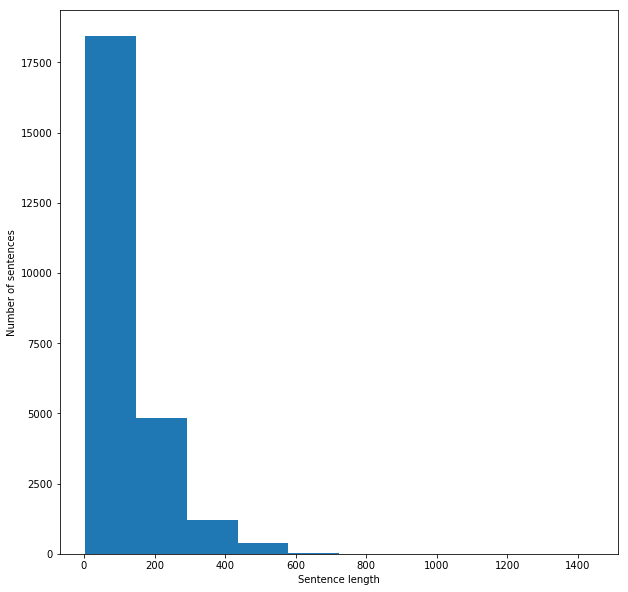

time: 289 ms


In [25]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [29]:
data_snt = data_snt.reindex(np.random.permutation(data_snt.index))

X = data_snt["cleaned_review"].astype(unicode)
y = data_snt["sentiment"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42 )

time: 11 ms


In [30]:
print("Creating Count vectors...")
X_train_counts, count_vectorizer = cv(X_train, analyzer=u'word')
X_test_counts = count_vectorizer.transform(X_test)
print 
print("Create Tf-Idf vectors...")
X_train_tfidf, tfidf_vectorizer = tfidf(X_train, analyzer=u'word')
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Creating Count vectors...
Vectors shape:  (19923, 66942) 

Create Tf-Idf vectors...
Vectors shape:  (19923, 13774) 

time: 25.5 s


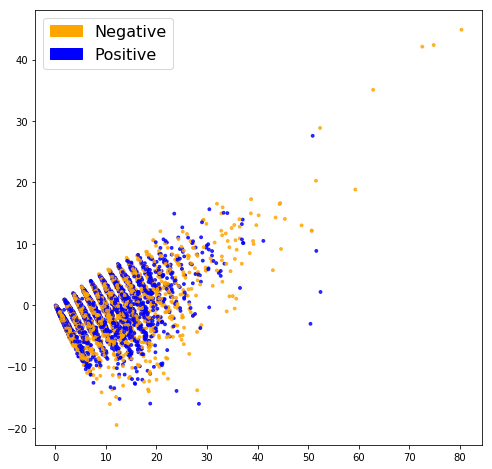

time: 1.33 s


In [31]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

By plotting the 2 classes of the data we can see that they are not so separated

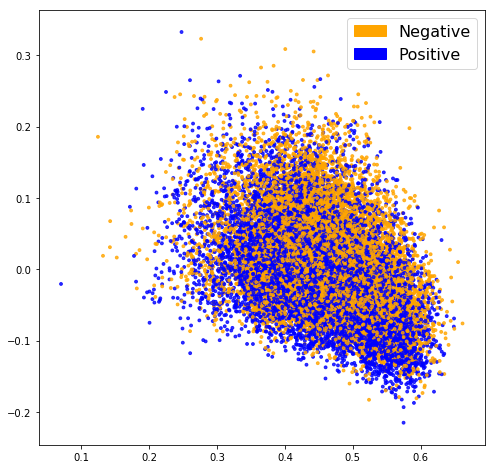

time: 1.56 s


In [32]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

By plotting the 2 classes of the data we can see that they much more separated compared to the count-based features

### Linear SGD Classifier

In [ ]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
def lsgd(x_train, y_train):
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier()),
    ])

    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 20000, 50000), # large numbers for large datasets 100,000+
        'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__alpha': (1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5),
        'clf__penalty': ('l2', 'l1', 'elasticnet'),
        'clf__max_iter': (50, 80, 100, 500, 1000),
        'clf__tol': (1e-3, 1e-4, 1e-5)
    }

    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected
        # block

        # find the best parameters for both the feature extraction and the
        # classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(x_train, y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

lsgd(X_train.values.tolist(), y_train.values.tolist())

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
 'clf__max_iter': (50, 80, 100, 500, 1000),
 'clf__penalty': ('l2', 'l1', 'elasticnet'),
 'clf__tol': (0.001, 0.0001, 1e-05),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 20000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 48600 candidates, totalling 145800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 93.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 135.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 174.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 218.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 267.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 321.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 381.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 445.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 516.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 591.7min
[Parallel(n_jobs=-1)]: Done 12784 tasks      | el

### Logistic Regression

In [46]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
def logreg(x_train, y_train):

    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(class_weight='balanced', solver='newton-cg'))
    ])

    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 20000),
        'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__C': (1.0, 10, 5.0, 2.0, 100),
        'clf__penalty': ('l2', 'l1'),
        'clf__max_iter': (10, 50, 80, 100),
        'clf__solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag'),
    }

    if __name__ == "__main__":
        # multiprocessing requires the fork 
#         to happen in a __main__ protected
        # block

        # find the best parameters for both the feature extraction and the
        # classifier
        grid_search = GridSearchCV(pipeline, parameters, verbose=1)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(x_train, y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
            
logreg(X_train.values.tolist(), y_train.values.tolist())

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (1.0, 10, 5.0, 2.0, 100),
 'clf__max_iter': (10, 50, 80, 100),
 'clf__penalty': ('l2', 'l1'),
 'clf__solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 20000),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 23040 candidates, totalling 69120 fits


KeyboardInterrupt: 

time: 2min 24s


### Linear SVM

In [ ]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
def linear_svm(x_train, y_train):
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC()),
    ])

    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 20000),
        'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__gamma': (0.001, 0.0001, 10, 100),
        'clf__C': (1, 100, 1000, 5, 10),
        'clf__kernel': ("linear", "rbf", "poly", "rbf", "sigmoid", "precomputed" )
    }

    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected
        # block

        # find the best parameters for both the feature extraction and the
        # classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(x_train, y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
linear_svm(X_train.values.tolist(), y_train.values.tolist())

# I will fit a model based on both Char-level and Word-level vectors

In [33]:
# Create Character-level features
print("Create Tf-Idf vectors char-level...")
X_train_tfidf_char, tfidf_vectorizer_char = tfidf(X_train, analyzer=u'char')
X_test_tfidf_char = tfidf_vectorizer_char.transform(X_test)

Create Tf-Idf vectors char-level...
Vectors shape:  (19923, 618) 

time: 11.5 s


In [34]:
# Stach char and word features together
from scipy.sparse import hstack

train_features = hstack([X_train_tfidf_char, X_train_tfidf])
test_features = hstack([X_test_tfidf_char, X_test_tfidf])

time: 232 ms


In [56]:
log_reg = LogisticRegression(C=0.8, class_weight='balanced', solver='sag', n_jobs=-1, random_state=42) 
log_reg.fit(train_features, y_train)
y_pred_log = log_reg.predict(test_features)
report_log = classification_report(y_test, y_pred_log)

print (report_log)

             precision    recall  f1-score   support

          0       0.81      0.80      0.80      2450
          1       0.81      0.81      0.81      2531

avg / total       0.81      0.81      0.81      4981

time: 2.1 s


In [39]:
# Test data features generating
# Create Character-level features
print("Create Tf-Idf vectors word-level...")
test_tfidf = tfidf_vectorizer.transform(data_test['cleaned_review'])
print("Create Tf-Idf vectors char-level...")
test_tfidf_char = tfidf_vectorizer_char.transform(data_test['cleaned_review'])

Create Tf-Idf vectors word-level...
Create Tf-Idf vectors char-level...
time: 51.9 s


In [40]:
testData_features = hstack([test_tfidf_char, test_tfidf])

time: 338 ms


In [41]:
testData_features.shape

(25000, 14392)

time: 3.16 ms


In [42]:
predictions = log_reg.predict(testData_features)

subm = pd.read_csv('data/sampleSubmission.csv')    
submid = pd.DataFrame({'id': subm["id"], 'sentiment': predictions})
submid.to_csv('submissions/sample_submission_Log.csv', index=False)

time: 851 ms


    ## I got AUC of 0.81676

In [43]:
sub_sg = SGDClassifier(alpha= 1e-05, max_iter= 10000, penalty= 'l2', n_jobs=-1, random_state=42)
sub_sg.fit(train_features, y_train)
y_pred = sub_sg.predict(test_features)
report = classification_report(y_test, y_pred)
print(report) 

             precision    recall  f1-score   support

          0       0.79      0.81      0.80      2450
          1       0.81      0.79      0.80      2531

avg / total       0.80      0.80      0.80      4981

time: 2min 59s


In [43]:
sub_sg = SGDClassifier(alpha= 1e-05, max_iter= 10000, penalty= 'l2', n_jobs=-1, random_state=42)
sub_sg.fit(train_features, y_train)
y_pred = sub_sg.predict(test_features)
report = classification_report(y_test, y_pred)
print(report) 

             precision    recall  f1-score   support

          0       0.79      0.81      0.80      2450
          1       0.81      0.79      0.80      2531

avg / total       0.80      0.80      0.80      4981

time: 2min 59s


In [44]:
predictions_sgd = sub_sg.predict(testData_features)

subm = pd.read_csv('data/sampleSubmission.csv')    
submid = pd.DataFrame({'id': subm["id"], 'sentiment': predictions_sgd})
submid.to_csv('submissions/sample_submission_sgd.csv', index=False)

time: 832 ms


    ## I got AUC of 0.79364

In [49]:
svm = LinearSVC(tol=0.001, C=0.1, class_weight='balanced',max_iter=1000, random_state=42)
svm.fit(train_features, y_train)
y_pred = sub_sg.predict(test_features)
report = classification_report(y_test, y_pred)
print(report) 

             precision    recall  f1-score   support

          0       0.79      0.81      0.80      2450
          1       0.81      0.79      0.80      2531

avg / total       0.80      0.80      0.80      4981

time: 897 ms


In [50]:
predictions_svm = svm.predict(testData_features)

subm = pd.read_csv('data/sampleSubmission.csv')    
submid = pd.DataFrame({'id': subm["id"], 'sentiment': predictions_sgd})
submid.to_csv('submissions/sample_submission_svm.csv', index=False)

time: 814 ms


    ## I got AUC of 0.79364